In [3]:
from tqdm.auto import tqdm 
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nf
from netCDF4 import Dataset
%matplotlib inline
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import ast,gc,pickle
from copy import deepcopy
import os

# Custom packages
import read_config
from util.data_process import read_vars, proc_dataset, miss
from util.models import performance_scores,train_baseline,causal_settings,train_PC1

In [4]:
# Read configuration file
config_set = read_config.read_config()
# Define Target
if int(config_set['target_lag'])==20:
    target='delv120'
if int(config_set['target_lag'])==16:
    target='delv96'
if int(config_set['target_lag'])==12:
    target='delv72'
if int(config_set['target_lag'])==8:
    target='delv48'
if int(config_set['target_lag'])==4:
    target='delv24'
seeds = np.arange(0,7,1)#np.arange(100,131,1)

In [5]:
seeds = np.arange(0,7,1)

In [6]:
seeds

array([0, 1, 2, 3, 4, 5, 6])

In [7]:
target

'delv24'

In [8]:
var_names = performance_scores.scores_seeds(seed=0,target=target,lag=int(config_set['target_lag']),exp='SHIPSERA5_noassum').read_stored()['var_names']

In [9]:
var_names[:]

Index(['delv24', 'pmin', 'wind10', 'out_t250', 'out_t200', 'spdx',
       'out_mean_midrhum', 'POT', 'POT2', 'PER',
       ...
       'tanom100', 'tanom150', 'tanom200', 'tanom250', 'tanom300', 'tanom400',
       'tanom500', 'tanom700', 'tanom850', 'tanom1000'],
      dtype='object', length=215)

In [10]:
len(performance_scores.scores_seeds(seed=0,target=target,lag=int(config_set['target_lag']),exp='SHIPSERA5_noassum').read_stored()['dataframes']['train'].keys())

184

In [11]:
print(var_names)

Index(['delv24', 'pmin', 'wind10', 'out_t250', 'out_t200', 'spdx',
       'out_mean_midrhum', 'POT', 'POT2', 'PER',
       ...
       'tanom100', 'tanom150', 'tanom200', 'tanom250', 'tanom300', 'tanom400',
       'tanom500', 'tanom700', 'tanom850', 'tanom1000'],
      dtype='object', length=215)


✅ Loaded all lead times: [24, 48, 72, 96, 120]
Total boxes: 20


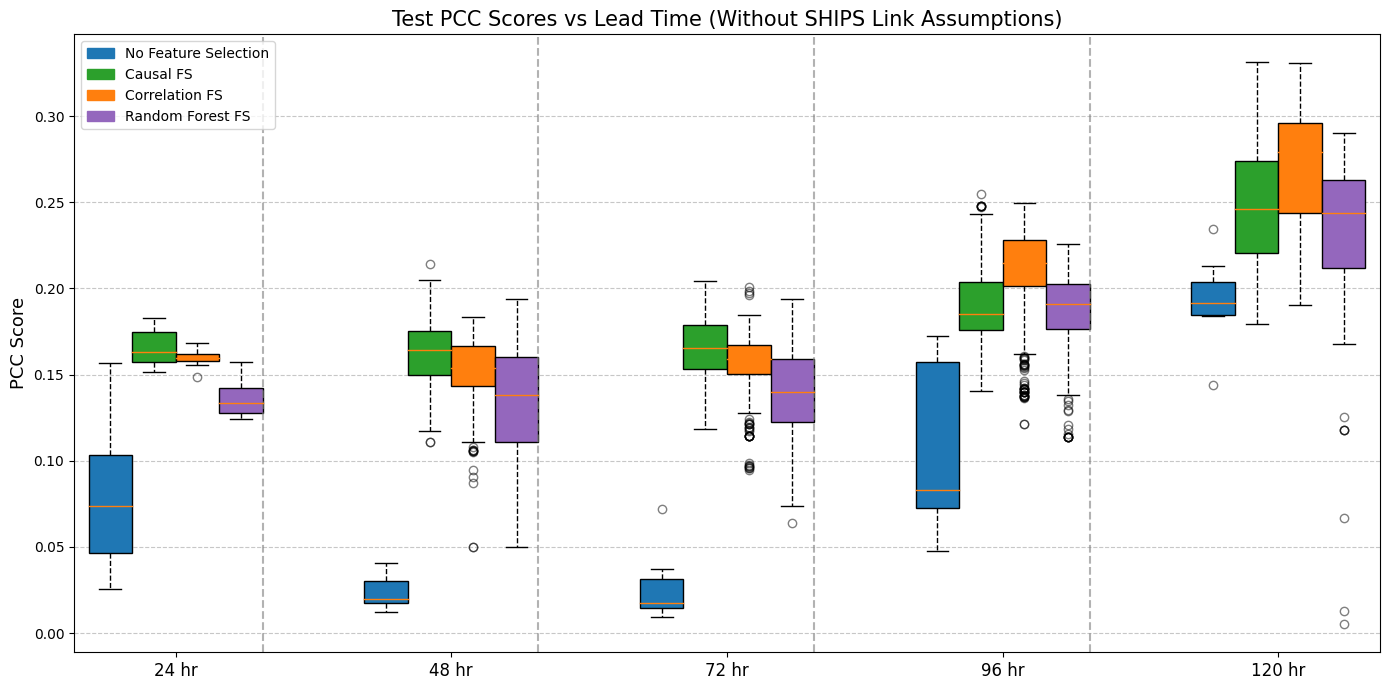

In [13]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# === Setup ===
lead_times = [24, 48, 72, 96, 120]
methods = ['noFS', 'causalFS', 'corrFS', 'XAIFS']
method_colors = ["#1f77b4", "#2ca02c", "#ff7f0e", "#9467bd"]  # consistent colors

# === 1. Load and collect test sets for each lead time ===
box_data = []  # Each item will be a list of test sets for each method per lead time
for lt in lead_times:
    with open(f'box_plot_pkl/pccbox_era5noassum_delv{lt}.pkl', 'rb') as f:
        pccbox = pickle.load(f)
    for method in methods:
        arr = np.asarray(pccbox[f"test_{method}"]).ravel()
        box_data.append(arr)

print(f"✅ Loaded all lead times: {lead_times}")
print(f"Total boxes: {len(box_data)}")

# === 2. Compute positions grouped by lead time ===
positions = []
start = 1
inner_gap = 0.6
group_gap = 2

for _ in lead_times:
    group_pos = [start + inner_gap * j for j in range(len(methods))]
    positions.extend(group_pos)
    start = group_pos[-1] + group_gap

colors = method_colors * len(lead_times)

# === 3. Plot ===
plt.figure(figsize=(14, 7))
box = plt.boxplot(box_data, patch_artist=True, positions=positions, widths=0.6)

# Color each box
for patch, color in zip(box["boxes"], colors):
    patch.set_facecolor(color)

for whisker in box["whiskers"]:
    whisker.set(color="black", linestyle="--")
for flier in box["fliers"]:
    flier.set(marker="o", color="black", alpha=0.5)

# Group centers for x-axis labels
group_centers = []
for i in range(len(lead_times)):
    group = positions[i*len(methods):(i+1)*len(methods)]
    group_centers.append(np.mean(group))

plt.xticks(group_centers, [f"{lt} hr" for lt in lead_times], fontsize=12)
plt.ylabel("PCC Score", fontsize=13)
plt.title("Test PCC Scores vs Lead Time (Without SHIPS Link Assumptions)", fontsize=15)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Vertical separators
for g in range(1, len(lead_times)):
    split_pos = positions[g*len(methods) - 1] + inner_gap/2
    plt.axvline(x=split_pos, color='grey', linestyle='--', alpha=0.6)

# Legend
legend_patches = [
    mpatches.Patch(color=method_colors[0], label="No Feature Selection"),
    mpatches.Patch(color=method_colors[1], label="Causal FS"),
    mpatches.Patch(color=method_colors[2], label="Correlation FS"),
    mpatches.Patch(color=method_colors[3], label="Random Forest FS"),
]
plt.legend(handles=legend_patches, loc="upper left")

plt.tight_layout()
plt.savefig('./figures/grouped_boxplot_noassum_pcc_test_vs_leadtime.png', dpi=300)
plt.show()


✅ Loaded all lead times: [24, 48, 72, 96, 120]
Total boxes: 20


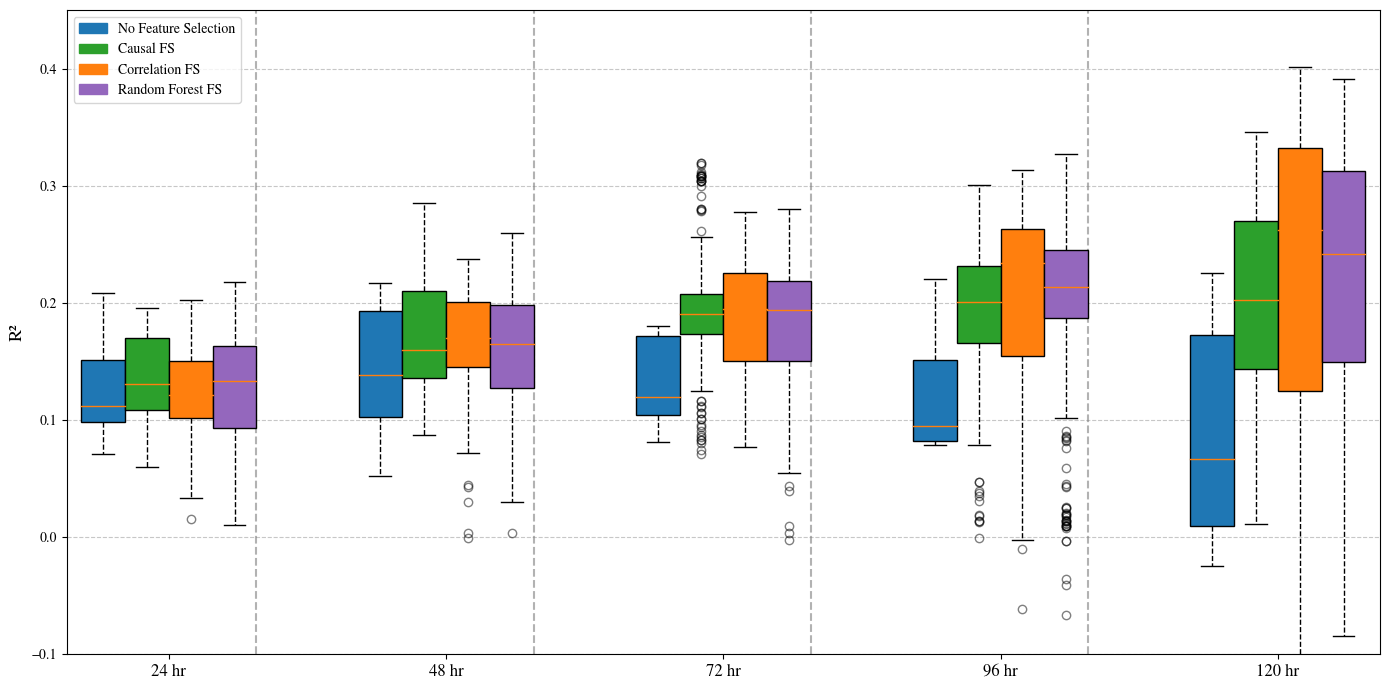

In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# === Use AMS-style serif font ===
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Nimbus Roman', 'Times', 'C059-Roman', 'P052-Roman', 'DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'stix'

# === Setup ===
lead_times = [24, 48, 72, 96, 120]
methods = ['noFS', 'causalFS', 'corrFS', 'XAIFS']
method_colors = ["#1f77b4", "#2ca02c", "#ff7f0e", "#9467bd"]  # consistent colors

# === 1. Load and collect VALIDATION sets for each lead time ===
box_data = []  # Each item will be a list of validation sets for each method per lead time
for lt in lead_times:
    with open(f'box_plot_pkl/r2box_era5wnoassum_delv{lt}.pkl', 'rb') as f:
        r2box = pickle.load(f)
    for method in methods:
        arr = np.asarray(r2box[f"valid_{method}"]).ravel()  # 🔄 Changed from test_ to valid_
        box_data.append(arr)

print(f"✅ Loaded all lead times: {lead_times}")
print(f"Total boxes: {len(box_data)}")

# === 2. Compute positions grouped by lead time ===
positions = []
start = 1
inner_gap = 0.6
group_gap = 2

for _ in lead_times:
    group_pos = [start + inner_gap * j for j in range(len(methods))]
    positions.extend(group_pos)
    start = group_pos[-1] + group_gap

colors = method_colors * len(lead_times)

# === 3. Plot ===
plt.figure(figsize=(14, 7))
box = plt.boxplot(box_data, patch_artist=True, positions=positions, widths=0.6)

# Color each box
for patch, color in zip(box["boxes"], colors):
    patch.set_facecolor(color)

for whisker in box["whiskers"]:
    whisker.set(color="black", linestyle="--")
for flier in box["fliers"]:
    flier.set(marker="o", color="black", alpha=0.5)

# Group centers for x-axis labels
group_centers = []
for i in range(len(lead_times)):
    group = positions[i*len(methods):(i+1)*len(methods)]
    group_centers.append(np.mean(group))

plt.xticks(group_centers, [f"{lt} hr" for lt in lead_times], fontsize=12)
plt.ylabel("R²", fontsize=13)
plt.ylim(-0.1, 0.45)
#plt.title("Validation R² Scores vs Lead Time (Without SHIPS Link Assumptions)", fontsize=15)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Vertical separators
for g in range(1, len(lead_times)):
    split_pos = positions[g*len(methods) - 1] + inner_gap/2
    plt.axvline(x=split_pos, color='grey', linestyle='--', alpha=0.6)

# Legend
legend_patches = [
    mpatches.Patch(color=method_colors[0], label="No Feature Selection"),
    mpatches.Patch(color=method_colors[1], label="Causal FS"),
    mpatches.Patch(color=method_colors[2], label="Correlation FS"),
    mpatches.Patch(color=method_colors[3], label="Random Forest FS"),
]
plt.legend(handles=legend_patches, loc="upper left")

plt.tight_layout()
plt.savefig('./figures/grouped_boxplot_noassum_r2_valid_vs_leadtime.png', dpi=300)  # 🔄 filename updated
plt.show()


/tmp/ipykernel_1121596/4276823905.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


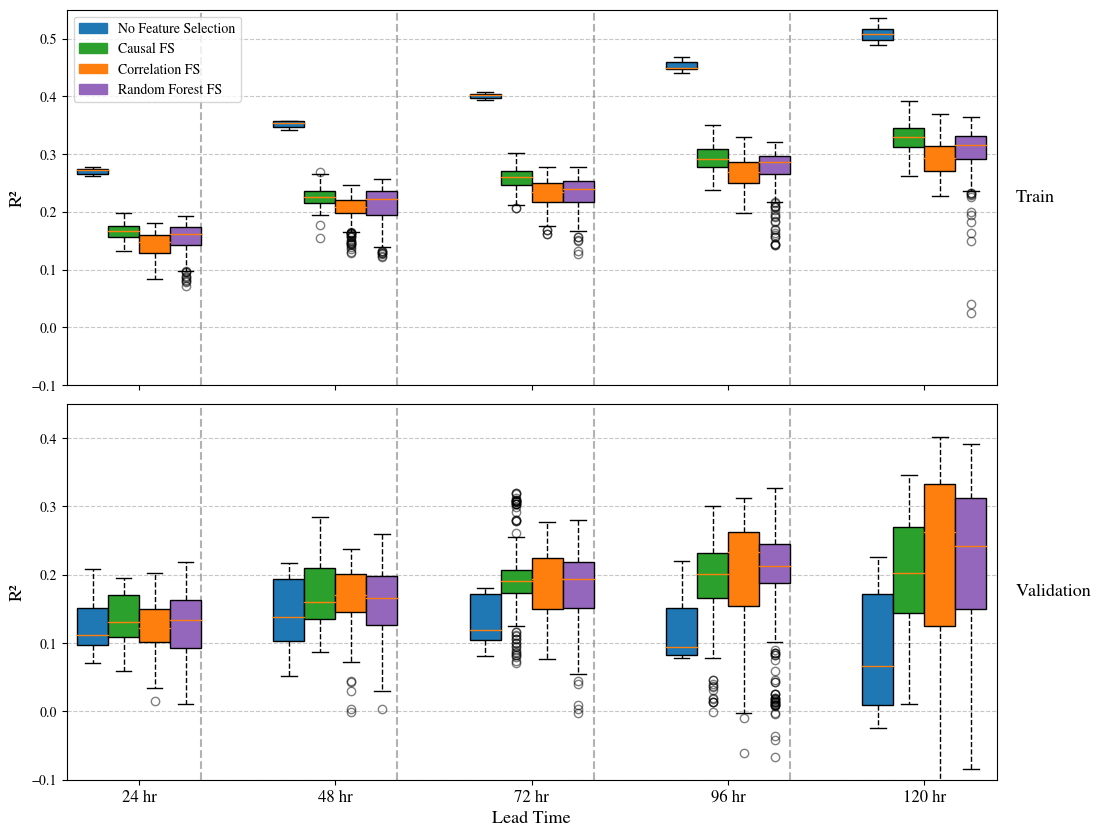

In [5]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# === Use AMS-style serif font ===
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Nimbus Roman', 'Times', 'C059-Roman', 'P052-Roman', 'DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'stix'

# === Setup ===
lead_times = [24, 48, 72, 96, 120]
methods = ['noFS', 'causalFS', 'corrFS', 'XAIFS']
method_colors = ["#1f77b4", "#2ca02c", "#ff7f0e", "#9467bd"]

# === 1. Load both train and validation R² scores ===
box_data_train = []
box_data_valid = []
for lt in lead_times:
    with open(f'box_plot_pkl/r2box_era5wnoassum_delv{lt}.pkl', 'rb') as f:
        r2box = pickle.load(f)
    for method in methods:
        box_data_train.append(np.asarray(r2box[f"train_{method}"]).ravel())
        box_data_valid.append(np.asarray(r2box[f"valid_{method}"]).ravel())

# === 2. Compute positions ===
positions = []
start = 1
inner_gap = 0.6
group_gap = 2

for _ in lead_times:
    group_pos = [start + inner_gap * j for j in range(len(methods))]
    positions.extend(group_pos)
    start = group_pos[-1] + group_gap

colors = method_colors * len(lead_times)

# === 3. Plot stacked panels ===
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True, gridspec_kw={'hspace': 0.05})

# Panel 1: Train
box1 = axs[0].boxplot(box_data_train, patch_artist=True, positions=positions, widths=0.6)
for patch, color in zip(box1["boxes"], colors):
    patch.set_facecolor(color)
for whisker in box1["whiskers"]:
    whisker.set(color="black", linestyle="--")
for flier in box1["fliers"]:
    flier.set(marker="o", color="black", alpha=0.5)

axs[0].set_ylim(-0.1, 0.55)
axs[0].set_ylabel("R²", fontsize=13)
axs[0].grid(axis="y", linestyle="--", alpha=0.7)
axs[0].text(1.02, 0.5, "Train", transform=axs[0].transAxes, fontsize=13, ha="left", va="center")

# Panel 2: Validation
box2 = axs[1].boxplot(box_data_valid, patch_artist=True, positions=positions, widths=0.6)
for patch, color in zip(box2["boxes"], colors):
    patch.set_facecolor(color)
for whisker in box2["whiskers"]:
    whisker.set(color="black", linestyle="--")
for flier in box2["fliers"]:
    flier.set(marker="o", color="black", alpha=0.5)

axs[1].set_ylim(-0.1, 0.45)
axs[1].set_ylabel("R²", fontsize=13)
axs[1].set_xlabel("Lead Time", fontsize=13)
axs[1].grid(axis="y", linestyle="--", alpha=0.7)
axs[1].text(1.02, 0.5, "Validation", transform=axs[1].transAxes, fontsize=13, ha="left", va="center")

# Group centers for ticks
group_centers = []
for i in range(len(lead_times)):
    group = positions[i * len(methods):(i + 1) * len(methods)]
    group_centers.append(np.mean(group))
axs[1].set_xticks(group_centers)
axs[1].set_xticklabels([f"{lt} hr" for lt in lead_times], fontsize=12)

# Vertical split lines for clarity
for ax in axs:
    for g in range(1, len(lead_times)):
        split_pos = positions[g * len(methods) - 1] + inner_gap / 2
        ax.axvline(x=split_pos, color='grey', linestyle='--', alpha=0.6)

# Legend (only once)
legend_patches = [
    mpatches.Patch(color=method_colors[0], label="No Feature Selection"),
    mpatches.Patch(color=method_colors[1], label="Causal FS"),
    mpatches.Patch(color=method_colors[2], label="Correlation FS"),
    mpatches.Patch(color=method_colors[3], label="Random Forest FS"),
]
axs[0].legend(handles=legend_patches, loc="upper left")

plt.tight_layout()
plt.savefig('./figures/stacked_boxplot_noassum_r2_train_valid_vs_leadtime.png', dpi=300)
plt.show()


✅ Loaded all lead times: [24, 48, 72, 96, 120]
Total boxes: 20


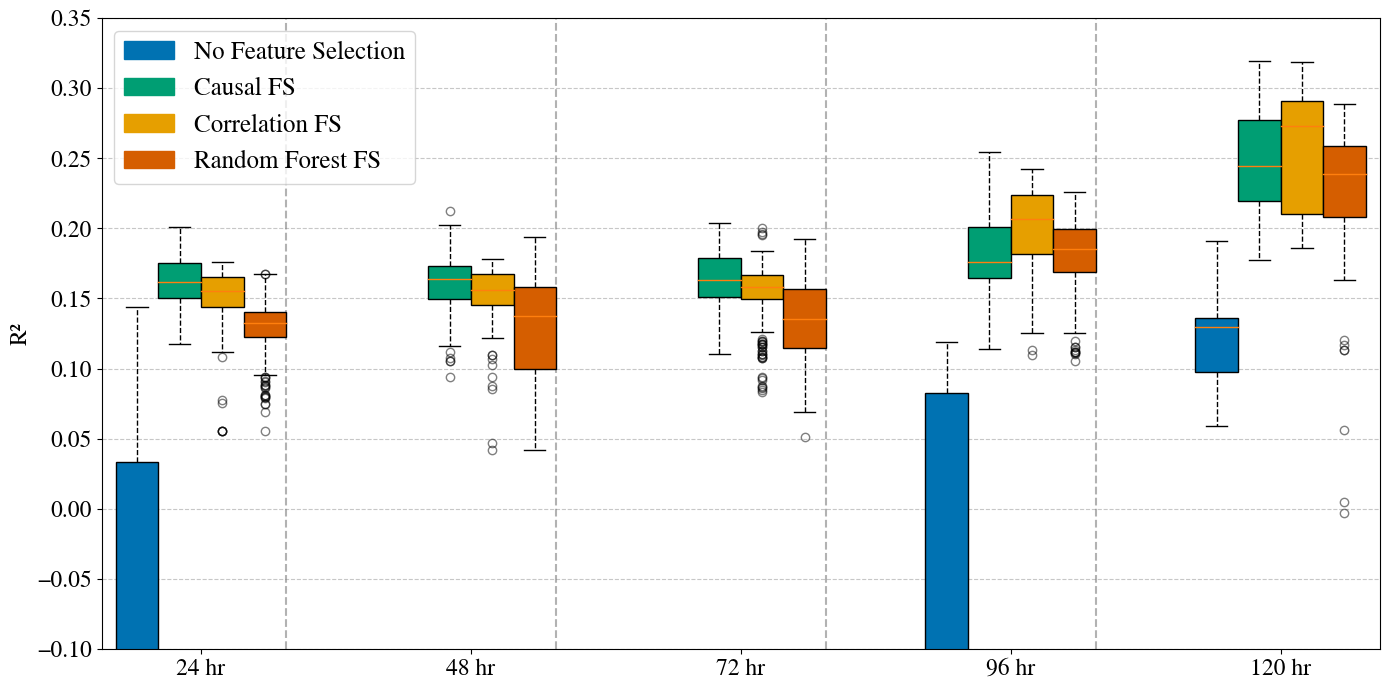

In [5]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# === Use AMS-style serif font ===
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Nimbus Roman', 'Times', 'C059-Roman', 'P052-Roman', 'DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'stix'

# === Setup ===
lead_times = [24, 48, 72, 96, 120]
methods = ['noFS', 'causalFS', 'corrFS', 'XAIFS']
method_colors = [
    "#0072B2",  # Blue  (NoFS)
    "#009E73",  # Bluish Green (CausalFS)
    "#E69F00",  # Orange (CorrelationFS)
    "#D55E00",  # Vermillion (XAIFS)
]

# === 1. Load and collect test sets for each lead time ===
box_data = []  # Each item will be a list of test sets for each method per lead time
for lt in lead_times:
    with open(f'box_plot_pkl/r2box_era5wnoassum_delv{lt}.pkl', 'rb') as f:
        r2box = pickle.load(f)
    for method in methods:
        arr = np.asarray(r2box[f"test_{method}"]).ravel()
        box_data.append(arr)

print(f"✅ Loaded all lead times: {lead_times}")
print(f"Total boxes: {len(box_data)}")

# === 2. Compute positions grouped by lead time ===
positions = []
start = 1
inner_gap = 0.6
group_gap = 2

for _ in lead_times:
    group_pos = [start + inner_gap * j for j in range(len(methods))]
    positions.extend(group_pos)
    start = group_pos[-1] + group_gap

colors = method_colors * len(lead_times)

# === 3. Plot ===
plt.figure(figsize=(14, 7))
box = plt.boxplot(box_data, patch_artist=True, positions=positions, widths=0.6)

# Color each box
for patch, color in zip(box["boxes"], colors):
    patch.set_facecolor(color)

for whisker in box["whiskers"]:
    whisker.set(color="black", linestyle="--")
for flier in box["fliers"]:
    flier.set(marker="o", color="black", alpha=0.5)

# Group centers for x-axis labels
group_centers = []
for i in range(len(lead_times)):
    group = positions[i*len(methods):(i+1)*len(methods)]
    group_centers.append(np.mean(group))

plt.xticks(group_centers, [f"{lt} hr" for lt in lead_times], fontsize=17)
plt.ylabel("R²", fontsize=17)
plt.yticks(fontsize=17)
plt.ylim(-0.1, 0.35)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Vertical separators
for g in range(1, len(lead_times)):
    split_pos = positions[g*len(methods) - 1] + inner_gap/2
    plt.axvline(x=split_pos, color='grey', linestyle='--', alpha=0.6)

# Legend
legend_patches = [
    mpatches.Patch(color=method_colors[0], label="No Feature Selection"),
    mpatches.Patch(color=method_colors[1], label="Causal FS"),
    mpatches.Patch(color=method_colors[2], label="Correlation FS"),
    mpatches.Patch(color=method_colors[3], label="Random Forest FS"),
]
plt.legend(handles=legend_patches, loc="upper left", fontsize=18)

plt.tight_layout()
plt.savefig('./figures/grouped_boxplot_noassum_r2_test_vs_leadtime.png', dpi=300)
plt.show()


✅ Loaded SHIPS+ERA5 FS and MLP for all lead times.
Total boxes: 25


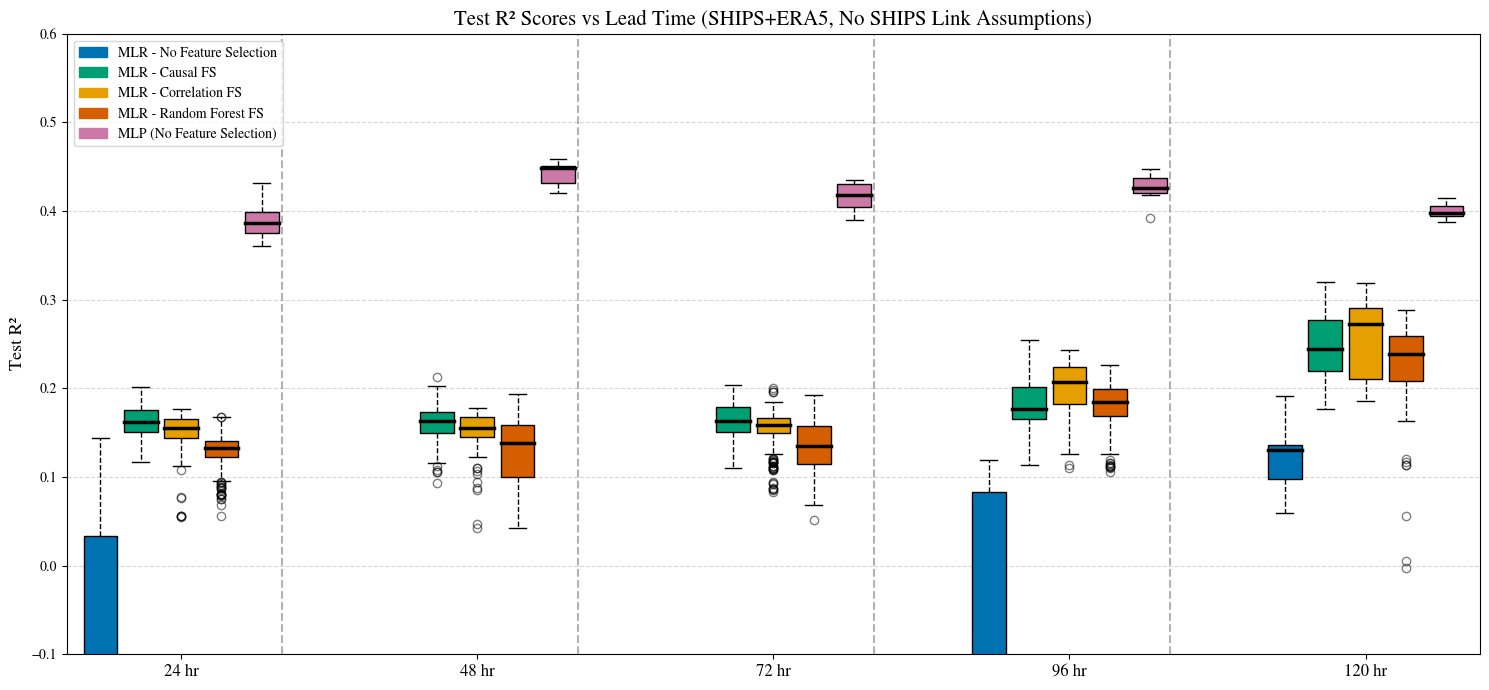

In [10]:
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# === Use AMS-style serif font ===
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Nimbus Roman', 'Times', 'C059-Roman', 'P052-Roman', 'DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'stix'

# === SETTINGS ===
lead_times = [24, 48, 72, 96, 120]
methods = ['noFS', 'causalFS', 'corrFS', 'XAIFS', 'MLP']

# Color Universal Design palette (colorblind-friendly)
method_colors = [
    "#0072B2",  # Blue  (NoFS)
    "#009E73",  # Bluish Green (CausalFS)
    "#E69F00",  # Orange (CorrelationFS)
    "#D55E00",  # Vermillion (XAIFS)
    "#CC79A7"   # Purple/Pink (MLP)
]

shipsera5_path = '/work/FAC/FGSE/IDYST/tbeucler/default/milton/causal_pkls/mlp_models_causal_no_fs.pkl'

def collect_r2_scores(mlp_pkl_path, leadtime='delv24'):
    """Collect test R² for each fold for given leadtime."""
    with open(mlp_pkl_path, 'rb') as f:
        folds = pickle.load(f)

    r2_test = []
    for k in folds.keys():
        if leadtime in k:
            fold = folds[k]
            if 'Evaluation Scores' in fold and 'test_r2' in fold['Evaluation Scores']:
                val = fold['Evaluation Scores']['test_r2']
                if isinstance(val, torch.Tensor):
                    val = val.item()
                r2_test.append(val)
            else:
                print(f"Missing 'test_r2' in {k}")
                r2_test.append(np.nan)

    return np.array(r2_test)

# === 1. Load & combine ===
box_data = []

for lt in lead_times:
    # Load SHIPS+ERA5 no assumptions FS methods
    with open(f'box_plot_pkl/r2box_era5wnoassum_delv{lt}.pkl', 'rb') as f:
        r2box = pickle.load(f)
    for method in methods[:-1]:  # all except MLP
        arr = np.asarray(r2box[f"test_{method}"]).ravel()
        box_data.append(arr)
    
    # Add MLP for this lead time
    arr_mlp = collect_r2_scores(shipsera5_path, leadtime=f'delv{lt}')
    box_data.append(arr_mlp)

print(f"✅ Loaded SHIPS+ERA5 FS and MLP for all lead times.")
print(f"Total boxes: {len(box_data)}")

# === 2. Positions ===
positions = []
start = 1
inner_gap = 0.6
group_gap = 2

for _ in lead_times:
    group_pos = [start + inner_gap * j for j in range(len(methods))]
    positions.extend(group_pos)
    start = group_pos[-1] + group_gap

colors = method_colors * len(lead_times)

# === 3. Plot ===
plt.figure(figsize=(15, 7))
box = plt.boxplot(box_data, patch_artist=True, positions=positions, widths=0.5)

# Fill colors
for patch, color in zip(box["boxes"], colors):
    patch.set_facecolor(color)

for whisker in box["whiskers"]:
    whisker.set(color="black", linestyle="--")
for flier in box["fliers"]:
    flier.set(marker="o", color="black", alpha=0.5)
for median in box["medians"]:
    median.set(color="black", linewidth=2.5)

# Group centers for x-axis labels
group_centers = []
for i in range(len(lead_times)):
    group = positions[i*len(methods):(i+1)*len(methods)]
    group_centers.append(np.mean(group))

plt.xticks(group_centers, [f"{lt} hr" for lt in lead_times], fontsize=12)
plt.ylabel("Test R²", fontsize=13)
plt.ylim(-0.10, 0.6)
plt.title("Test R² Scores vs Lead Time (SHIPS+ERA5, No SHIPS Link Assumptions)", fontsize=15)
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Vertical separators
for g in range(1, len(lead_times)):
    split_pos = positions[g*len(methods) - 1] + inner_gap/2
    plt.axvline(x=split_pos, color='grey', linestyle='--', alpha=0.6)

# === Legend ===
legend_patches = [
    mpatches.Patch(color=method_colors[0], label="MLR - No Feature Selection"),
    mpatches.Patch(color=method_colors[1], label="MLR - Causal FS"),
    mpatches.Patch(color=method_colors[2], label="MLR - Correlation FS"),
    mpatches.Patch(color=method_colors[3], label="MLR - Random Forest FS"),
    mpatches.Patch(color=method_colors[4], label="MLP (No Feature Selection)")
]
plt.legend(handles=legend_patches, loc="upper left")

plt.tight_layout()
plt.savefig('./figures/grouped_boxplot_r2_test_vs_leadtime_FS_plus_MLP_colorblind.png', dpi=300)
plt.show()


In [291]:
print(folds[k]['r2_scores'].keys())

dict_keys(['train', 'valid', 'test'])


## Sample size

In [55]:
import numpy as np

def get_sample_size(score_list, split='test'):
    """
    Returns total number of samples across all folds & models for a given split.
    Handles various nested structures.
    """
    count = 0

    if not score_list:
        return 0

    first = score_list[0]

    if isinstance(first, dict):
        for fold_data in score_list:
            y_data = fold_data['y']
            if isinstance(y_data, dict):
                y = np.asarray(y_data[split]).ravel()
            elif isinstance(y_data, list):
                if isinstance(y_data[0], dict):
                    y = np.concatenate([np.asarray(yd[split]).ravel() for yd in y_data])
                else:
                    y = np.concatenate([np.asarray(arr).ravel() for arr in y_data])
            else:
                y = np.asarray(y_data).ravel()
            count += len(y)

    elif isinstance(first, list):
        for fold in score_list:
            for model in fold:
                y_data = model['y']
                if isinstance(y_data, dict):
                    y = np.asarray(y_data[split]).ravel()
                elif isinstance(y_data, list):
                    if isinstance(y_data[0], dict):
                        y = np.concatenate([np.asarray(yd[split]).ravel() for yd in y_data])
                    else:
                        y = np.concatenate([np.asarray(arr).ravel() for arr in y_data])
                else:
                    y = np.asarray(y_data).ravel()
                count += len(y)

    else:
        raise ValueError("Unknown structure")

    return count

In [56]:
# Example for one lead time:
lead_time = 120

# Example for your dict:
score_dict = {
    'noFS': score_nocausal,
    'causalFS': score_causal,
    'corrFS': score_correlation,
    'XAIFS': score_corr
}

splits = ['train', 'valid', 'test']

print(f"=== Sample Sizes for Lead Time {lead_time} ===")

for split in splits:
    print(f"\n{split.capitalize()} Set:")
    for method in score_dict:
        n = get_sample_size(score_dict[method], split=split)
        print(f"  {method}: {n}")


=== Sample Sizes for Lead Time 120 ===

Train Set:
  noFS: 18534
  causalFS: 593088
  corrFS: 1167642
  XAIFS: 556020

Valid Set:
  noFS: 3089
  causalFS: 98848
  corrFS: 194607
  XAIFS: 92670

Test Set:
  noFS: 2205
  causalFS: 70560
  corrFS: 138915
  XAIFS: 66150


## TO PLOT THE STORM TRACK FOR CASE SELECTED!

In [6]:
import tropycal.tracks as tracks

# ✅ Load IBTrACS from your local file
ibtracs = tracks.TrackDataset(
    basin='north_atlantic',
    source='ibtracs',
    ibtracs_url='../besttracks/ibtracs.NA.list.v04r01.csv'
)



--> Starting to read in ibtracs data
--> Completed reading in ibtracs data (4.99 seconds)


In [7]:
# Get Hurricane Isaias (2020)
storm = ibtracs.get_storm(('LARRY', 2021))

print(storm)


<tropycal.tracks.Storm>
Storm Summary:
    Maximum Wind:      110 knots
    Minimum Pressure:  953 hPa
    Start Time:        1800 UTC 31 August 2021
    End Time:          0600 UTC 11 September 2021

Variables:
    time        (datetime) [2021-08-31 18:00:00 .... 2021-09-11 18:00:00]
    extra_obs   (int64) [0 .... 0]
    special     (str) [ .... ]
    type        (str) [TD .... EX]
    lat         (float64) [11.5 .... 55.3]
    lon         (float64) [-20.6 .... -46.8]
    vmax        (int64) [30 .... 55]
    mslp        (int64) [1006 .... 967]
    wmo_type    (str) [TS .... ET]
    wmo_lat     (float64) [11.5 .... 55.3]
    wmo_lon     (float64) [-20.6 .... -46.8]
    wmo_vmax    (int64) [30 .... 55]
    wmo_mslp    (int64) [1006 .... 967]
    wmo_basin   (str) [north_atlantic .... north_atlantic]

More Information:
    id:              AL122021
    operational_id:  
    name:            LARRY
    year:            2021
    season:          2021
    basin:           north_atlantic
   

In [8]:
df= storm.to_dataframe()

In [9]:

from matplotlib.colors import Normalize

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.cm import ScalarMappable

def plot_storm_track_fancy(
    df,
    storm_name='Storm',
    basin_extent=None,
    pad=2,
    figsize=(10, 8),
    save_path=None
):
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Add land & ocean
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linestyle=':', edgecolor='gray')

    # === Intensity coloring ===
    intensity = df['vmax']
    lon = df['lon']
    lat = df['lat']

    # Create custom colormap: blue -> violet -> dark red
    colors = [
        (0, 'royalblue'),
        (0.5, 'violet'),
        (1, 'darkred')
    ]
    custom_cmap = LinearSegmentedColormap.from_list('blue_red', colors)
    norm = Normalize(vmin=intensity.min(), vmax=intensity.max())

    # Scatter points colored by intensity
    sc = ax.scatter(lon, lat, c=intensity, cmap=custom_cmap, norm=norm,
                    edgecolor='k', s=50, zorder=3)

    # Connect points with line for continuity
    ax.plot(lon, lat, color='gray', linestyle='-', zorder=2)

    # Map extent
    if basin_extent:
        ax.set_extent(basin_extent)
    else:
        lat_min = lat.min() - pad
        lat_max = lat.max() + pad
        lon_min = lon.min() - pad
        lon_max = lon.max() + pad
        ax.set_extent([lon_min, lon_max, lat_min, lat_max])

    # Gridlines
    gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5)
    gl.top_labels = False
    gl.right_labels = False

    # Colorbar
    cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=custom_cmap),
                        ax=ax, orientation='vertical', pad=0.02,
                        label='Max Wind Speed (kt)')

    plt.title(f'{storm_name} Track with Intensity', fontsize=14)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Saved plot to: {save_path}")

    plt.show()


In [12]:
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable

def plot_storm_track_fancy(
    df,
    storm_name='Storm',
    basin_extent=None,
    pad=5,
    figsize=(12, 10),
    save_path=None
):
    import pandas as pd
    from matplotlib.colors import Normalize, LinearSegmentedColormap
    from matplotlib.cm import ScalarMappable
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature

    df = df.copy()
    df['time'] = pd.to_datetime(df['time'])
    start_time = pd.Timestamp('2021-08-31 18:00:00')
    end_time = pd.Timestamp('2021-09-09 06:00:00')
    df = df[(df['time'] >= start_time) & (df['time'] <= end_time)]
    df = df.iloc[::2].reset_index(drop=True)

    intensity = df['vmax']
    lon = df['lon']
    lat = df['lat']

    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection=ccrs.PlateCarree())

    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linestyle=':', edgecolor='gray')

    # === Intensity coloring ===
    colors = [(0, 'royalblue'), (0.5, 'violet'), (1, 'darkred')]
    custom_cmap = LinearSegmentedColormap.from_list('blue_red', colors)
    norm = Normalize(vmin=intensity.min(), vmax=intensity.max())
    sc = ax.scatter(lon, lat, c=intensity, cmap=custom_cmap, norm=norm,
                    edgecolor='k', s=50, zorder=3)
    ax.plot(lon, lat, color='gray', linestyle='-', zorder=2)

    if basin_extent:
        ax.set_extent(basin_extent)
    else:
        lat_min = lat.min() - pad
        lat_max = lat.max() + pad
        lon_min = lon.min() - pad
        lon_max = lon.max() + pad
        ax.set_extent([lon_min, lon_max, lat_min, lat_max])

    # Gridlines with larger labels
    gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 16, 'weight': 'bold'}
    gl.ylabel_style = {'size': 16, 'weight': 'bold'}

    # Colorbar with larger label
    cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=custom_cmap),
                        ax=ax, orientation='vertical', pad=0.02,
                        label='Max Wind Speed (kt)')
    cbar.ax.tick_params(labelsize=16)

    #plt.title(f'{storm_name} Track with Intensity', fontsize=18, fontweight='bold')

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Saved plot to: {save_path}")

    plt.show()


✅ Saved plot to: figures/Larry_intensity.png


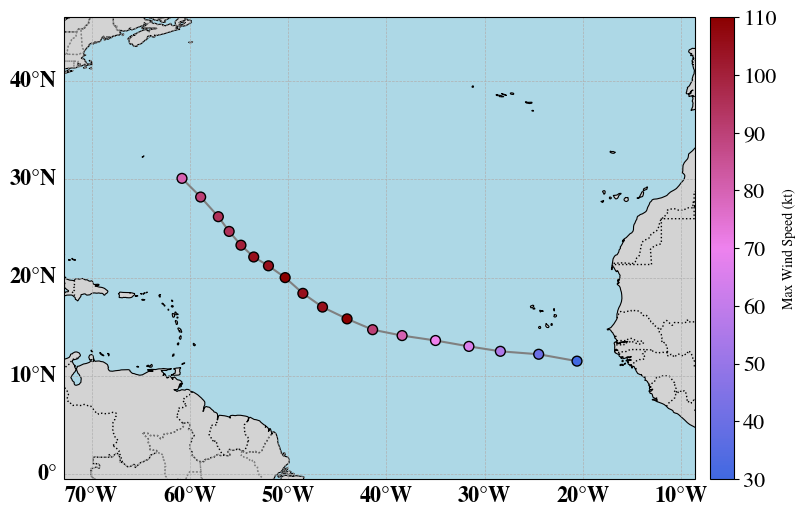

In [13]:
plot_storm_track_fancy(
    df,
    storm_name='Hurricane Larry (2021)',
    basin_extent=None,
    pad=12,
    figsize=(10, 6),
    save_path='figures/Larry_intensity.png'
)


In [24]:
print(df.columns)

Index(['time', 'extra_obs', 'special', 'type', 'lat', 'lon', 'vmax', 'mslp',
       'wmo_type', 'wmo_lat', 'wmo_lon', 'wmo_vmax', 'wmo_mslp', 'wmo_basin'],
      dtype='object')
